## Adaptive-RAG
- Corrective-RAG에 Query Router를 추가한 버전
- 사용자 질문이 들어오면 맨 처음에 query_router를 통해 질문을 분석하고 적절한 경로로 라우팅
- 라우팅 경로
  - 'vector_store': 소득세 관련 질문 → retriever로 문서 검색
  - 'web_search': 최신 정보가 필요한 질문 → 웹 검색
  - 'basic_generate': 간단한 질문 → LLM이 직접 답변
- vector_store 경로의 경우 Corrective-RAG와 동일한 검증 로직 수행 (문서 관련성, 할루시네이션, 유용성 검증)
- 검증 실패 시 웹 검색으로 fallback 가능

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

# 기존에 생성한 vector store 불러오기 
vector_store = Chroma(
    embedding_function=embeddings,
    collection_name = 'income_tax_collection',
    persist_directory = '../income_tax_collection' #로컬에 영구 저장 버전 
)

In [3]:
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [4]:
# State 정의 
from typing import Literal
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

RELEVANCE_LITERAL = Literal["relevant", "irrelevant"]
HALLUCINATION_LITERAL = Literal["grounded", "hallucinated"]
HELPFULNESS_LITERAL = Literal["helpful", "unhelpful"] 

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

    # 검증 결과 
    doc_relevance_status: RELEVANCE_LITERAL
    hallucination_status: HALLUCINATION_LITERAL
    helpfulness_status: HELPFULNESS_LITERAL
    web_relevance_status: RELEVANCE_LITERAL

    # 검증 시도 횟수 
    rewrite_count: int      # 질문 재작성 시도 횟수 
    generation_count: int   # LLM 답변 생성 시도 횟수 
    web_search_count: int  # 웹 검색 시도 횟수 \

In [5]:
# Node 정의
# 사용자 query로 vector store에서 검색을 수행하는 노드 
def retrieve(state: AgentState) -> AgentState:
    query = state['query']
    
    docs = retriever.invoke(query)

    return {'context': docs}

In [6]:
from langchain_openai import ChatOpenAI
from langsmith import Client

llm = ChatOpenAI(model='gpt-4o-mini')
client = Client()

In [7]:
# context와 query를 받아서 LLM 답변을 생성하는 노드 
def generate(state: AgentState) -> AgentState:
    context = state['context']
    query = state['query']
    
    prompt = client.pull_prompt("rlm/rag-prompt")
    rag_chain = prompt | llm
    response = rag_chain.invoke({'question': query, 'context': context})

    return {'answer': response.content, 'generation_count': state['generation_count']+1}

In [8]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 검색 결과의 정확도를 높이도록 사용자 쿼리를 변환하는 노드 
def rewrite(state: AgentState) -> AgentState:
    query = state['query']
    dictionary = ["사람을 나타내는 표현 -> 거주자"]

    keyword_dictionary_prompt = PromptTemplate.from_template(
        f"""사용자의 질문을 보고, 키워드 사전을 참고해서 사용자의 질문을 변경해주세요. 
        사전: {dictionary}
        사용자의 질문: {{question}}
        """
    )
    keyword_dictionary_chain = keyword_dictionary_prompt| llm | StrOutputParser()
    rewritten_query = keyword_dictionary_chain.invoke({'question': query})

    return {'query': rewritten_query, 'rewrite_count': state['rewrite_count']+1}

In [9]:
validation_llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [10]:
def check_relevance(query, context):
    doc_relevance_prompt = client.pull_prompt("rlm/rag-document-relevance")

    doc_relevance_chain = doc_relevance_prompt | validation_llm

    response = doc_relevance_chain.invoke({
        "input": {
            "question": query,
            "documents": context
        }
    })
    
    # doc_relevance_chain의 결과: 문서 관련성이 높으면 1, 아니면 0 
    if response['Score'] == 1:
        return "relevant"
    else:
        return "irrelevant"

In [11]:
# retriver에서 검색한 문서의 관련성을 판단하는 노드 
def check_doc_relevance(state: AgentState):
    query = state['query'] 
    context = state['context']

    result = check_relevance(query, context)

    return {"doc_relevance_status": result}

def route_after_doc_relevance(state: AgentState):
    result = state["doc_relevance_status"]
    if(result == "relevant"):
        return "generate"
    else:
        if(state['rewrite_count'] >= 2): # 2번 재작성했는데도 "irrelevant"면 웹 검색 
            return "web_search_rewrite"
        else:
            return "rewrite"

In [12]:
# 할루시네이션 검증 노드  
def check_hallucination(state: AgentState):
    context = state["context"]
    answer = state["answer"]

    hallucination_prompt = PromptTemplate.from_template("""
        당신은 학생의 답변이 제공된 문서에 기반했는지 평가하는 선생님입니다.
        소득세법에서 발췌한 문서들과 학생의 답변이 주어집니다.
        학생의 답변이 문서에 기반한 경우 "grounded"로 응답하세요.
        학생의 답변이 문서에 기반하지 않은 경우 "hallucinated"로 응답하세요.
        단, 학생이 "잘 모르겠습니다", "문서에 해당 정보가 없습니다" 등으로 솔직하게 답변한 경우에도 "grounded"로 판단하세요.

        문서: {documents}
        학생의 답변: {student_answer}
        """
    )

    hallucinations_chain = hallucination_prompt | validation_llm | StrOutputParser()
    
    # 평가 실행
    response = hallucinations_chain.invoke({
        "documents": context,
        "student_answer": answer 
    })

    # 판단 결과를 State에 업데이트합니다.
    return {"hallucination_status": response}

def route_after_hallucination(state: AgentState):
    result = state["hallucination_status"]
    if(result == "grounded"):
        return "check_helpfulness"
    else:
        if(state['generation_count'] >= 4): # 3번 재생성했는데도 "hallucinated"면 답변 작성 실패 (초기 1번은 재생성이 아니므로 제외)
            return "inform_failure"
        else:
            return "generate"

In [13]:
# 유용성 검증 노드 
from langgraph.graph import END

def check_helpfulness(state:AgentState):
    query = state['query']
    answer = state['answer']

    # Hub에서 검증된 프롬프트 가져오기
    helpfulness_prompt = client.pull_prompt("rlm/rag-answer-helpfulness")

    helpfulness_chain = helpfulness_prompt | validation_llm
    
    # 평가 실행
    response = helpfulness_chain.invoke({
        "input": {
            "question": query  
        },
        "output": answer 
    })
    
    score = response["Score"]
    if(score == 1):
        return {"helpfulness_status": "helpful"}
    else:
        return {"helpfulness_status": "unhelpful"}

def route_after_helpfulness(state: AgentState):
    result = state["helpfulness_status"]
    if(result == "helpful"):
        return "helpful"
    else:
        if(state['web_search_count'] == 0):
            return "web_search_rewrite"
        else:
            return "inform_failure"

In [14]:

def inform_failure(state: AgentState) -> AgentState:
    # 기존에 생성되었던 답변(정직한 거절 답변 등)을 가져옵니다.
    existing_answer = state.get("answer", "관련 정보를 찾을 수 없습니다.")
    
    # 실패 안내 메시지를 조금 더 전문적으로 구성합니다.
    failure_message = (
        f"--- [최종 확인 결과] ---\n"
        f"{existing_answer}\n\n"
        f"------------------------\n"
        f"💡 안내: 내부 문서를 확인했으나 질문에 대한 더 구체적인 확답을 드리기 어려운 상태입니다. "
        f"질문을 조금 더 구체적으로(예: 연도, 특정 상황 등) 바꿔서 다시 물어봐 주시면 감사하겠습니다."
    )
    
    return {"answer": failure_message}

In [15]:
# 사용자 쿼리를 웹 검색에 적합하도록 변환하는 노드 
def web_search_rewrite(state: AgentState) -> AgentState:
    query = state['query'] #사용자 원본 질문 사용 
    
    web_search_rewrite_prompt = PromptTemplate.from_template(
        f""" 아래 질문을 웹 검색에서 가장 최신의 정확한 정보를 찾을 수 있는 검색어로 변환해주세요. 
        질문: {query}
        """
    )
    web_search_rewrite_chain = web_search_rewrite_prompt | llm | StrOutputParser()
    rewritten_query = web_search_rewrite_chain.invoke({'query': query})

    return {'query': rewritten_query, 'generation_count': 0} # 웹 검색 재작성을 위해 generation 카운트 초기화

In [16]:
from langchain_tavily import TavilySearch

tavily_search_tool = TavilySearch(
    max_results=3, # 디폴트 5 
    search_depth="advanced" # 디폴트 "basic"
)

In [17]:
#web_results = tavily_search_tool.invoke("봉천동 양꼬치 맛집 추천 리스트 블로그 포스팅 맛 평가")
#print(web_results)

In [18]:
def web_search(state: AgentState) -> AgentState:
    # 1. 기존 context 가져오기
    existing_context = state.get('context', [])
    
    # 2. 웹 검색 수행 
    query = state['query']
    web_results = tavily_search_tool.invoke(query)
    
    # 3. 검색 결과를 metadata가 포함된 Document 객체로 변환
    new_docs = []
    for result in web_results["results"]:
        full_content = f"제목: {result.get('title', '')}\n내용: {result.get('content', '')}"
        doc = Document(
            page_content=full_content,
            metadata={
                "category": "web_search", 
                "source": result.get("url", "unknown"),
                "score": result.get("score", 0)
            }
        )
        new_docs.append(doc)
    
    # 4. 기존 context 뒤에 새 정보 붙이기
    return {"context": existing_context + new_docs, 'web_search_count': state['web_search_count']+1}

In [19]:
def check_web_relevance(state: AgentState):
    context = state['context']
    query = state['query']
    
    result = check_relevance(query, context)

    return {"web_relevance_status": result}

def route_after_web_relevance(state: AgentState):
    status = state["web_relevance_status"]
    
    if status == "relevant":
        return "generate"        
    else:
        return "inform_failure"  #웹 검색 재시도 안함 

In [20]:
from langchain_core.prompts import ChatPromptTemplate


def query_router(state: AgentState) -> Literal['vector_store', 'llm', 'web_search']:
    query = state['query']

    query_router_system_prompt = """
    당신은 사용자의 질문을 'vector_store','web_search', 또는 'basic_generate'로 라우팅하는 전문가입니다.
    아래의 설명을 보고 사용자의 질문에 가장 적절한 경로를 선택해주세요.
    1. 'vector_store'는 2024년 12월까지의 소득세 관련 정보를 포함하고 있습니다. 소득세 관련 질문에 대해서는 'vector_store'를 선택하세요. 
    2. 질문에 답하기 위해 웹 검색이 필요하다고 생각되면 'web_search'를 선택하세요. 질문이 소득세 관련 질문이지만, 2024년 12월 이후의 최근 정보를 필요로 하는 경우에는 'web_search'를 선택하세요. 
    3. 질문이 충분히 쉬운 질문이면 'basic_generate'을 선택하세요. 
    중요: 답변은 무조건 vector_store, web_search, basic_generate 중 하나의 단어만 정확히 출력하세요. 다른 설명이나 문장은 절대 포함하지 마세요.
    """

    query_router_prompt = ChatPromptTemplate.from_messages([
        ("system", query_router_system_prompt),
        ("user", "{query}")
    ])

    query_router_chain = query_router_prompt | llm | StrOutputParser()

    route = query_router_chain.invoke({'query': query})

    return route


In [21]:
def basic_generate(state: AgentState) -> AgentState:
    query = state['query']
    response = llm.invoke(query)
    return {'answer': response.content}

In [22]:
from langgraph.graph import StateGraph, START, END

#  그래프 빌더 생성 
graph_builder = StateGraph(AgentState)

# 노드 추가 
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_node("rewrite", rewrite)
graph_builder.add_node("check_doc_relevance", check_doc_relevance)
graph_builder.add_node("check_hallucination", check_hallucination)
graph_builder.add_node("check_helpfulness", check_helpfulness)
graph_builder.add_node("inform_failure", inform_failure)

graph_builder.add_node("web_search_rewrite", web_search_rewrite)
graph_builder.add_node("web_search", web_search)
graph_builder.add_node("check_web_relevance", check_web_relevance)

graph_builder.add_node("basic_generate", basic_generate)


In [23]:
from langgraph.graph import START, END
# 엣지 추가 
graph_builder.add_conditional_edges(
    START,
    query_router,
    {
        "vector_store": "retrieve",
        "web_search": "web_search_rewrite",
        "basic_generate": "basic_generate"
    }
)
graph_builder.add_edge("retrieve", "check_doc_relevance")
graph_builder.add_conditional_edges(
    "check_doc_relevance", 
    route_after_doc_relevance,
    {
        "generate": "generate", #relevant
        "rewrite": "rewrite", #irrelevant
        "web_search_rewrite": "web_search_rewrite" # 2번 재작성 + irrelevant 
    }
)
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge("generate", "check_hallucination")
graph_builder.add_conditional_edges(
    "check_hallucination", 
    route_after_hallucination,
    {
        "check_helpfulness": "check_helpfulness", #grounded
        "generate": "generate", #hallucinated
        "inform_failure": "inform_failure" # 3번 재생성 + hallucinated
    }
)
graph_builder.add_conditional_edges(
    "check_helpfulness",
    route_after_helpfulness,
    {   "helpful": END, #helpful
        "web_search_rewrite": "web_search_rewrite", # 웹 검색 시도 0회 + unhelpful
        "inform_failure": "inform_failure" # 웹 검색 시도 1회 이상 + unhelpful
    }
)
graph_builder.add_edge("web_search_rewrite", "web_search")
graph_builder.add_edge("web_search", "check_web_relevance")
graph_builder.add_conditional_edges(
    "check_web_relevance",
    route_after_web_relevance,
    {
        "generate": "generate", #relevant
        "inform_failure": "inform_failure" #irrelevant
    }
)

graph_builder.add_edge("inform_failure", END)
graph_builder.add_edge("basic_generate", END)

In [24]:
# 그래프 생성 
graph = graph_builder.compile() 

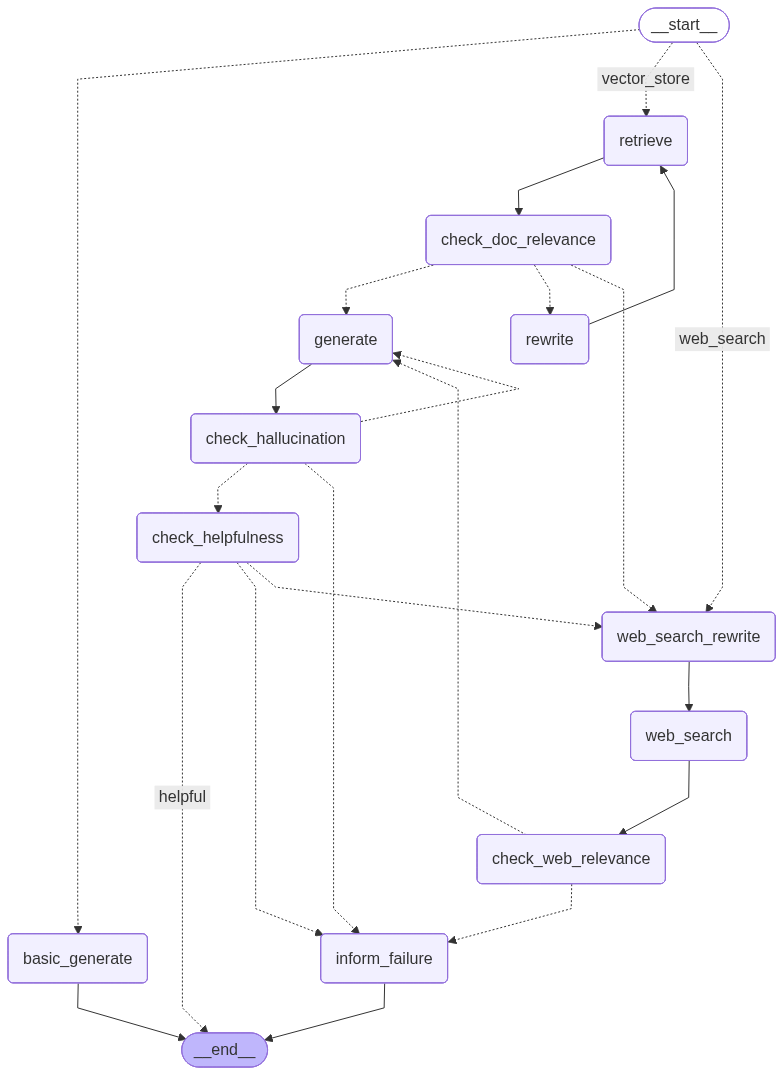

In [25]:
# 그래프 시각화 
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
#query = '연봉 5천만원인 직장인의 소득세는 얼마인가요?'
#query = '소득세법 제70조에 따른 거주자 종합소득 과세표준을 계산할 때, 2026년에 새로 도입되는 AI 특별 공제 항목도 포함해야 하나요?'
query = "2026년 기준 소득세 과세표준은 얼마인가요?"
# 그래프 실행 
initial_state = {
    'query': query,
    'rewrite_count': 0,      # 초기값 0으로 설정
    'generation_count': 0,
    'web_search_count': 0   
} 

In [27]:
result = graph.invoke(initial_state)

In [28]:
print(result.get('answer'))

2026년 소득세 과세표준은 다양한 구간에 따라 세율이 다르게 적용됩니다. 예를 들어, 소득이 1,400만 원 이하일 경우 6%의 세율이 적용되며, 1억 5,000만 원 초과시 38%의 세율이 적용됩니다. 이와 함께 누진공제액도 각 구간별로 다르게 설정되어 있습니다.
